In [268]:
import pandas as pd
import numpy as np
import os
from StringIO import StringIO

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process, dummy

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

#Configure visualizations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 12 , 8

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

ImportError: No module named ggplot

In [77]:
DATA_DIR = os.path.join("..", "data")


data_files = [i for i in os.listdir(DATA_DIR) if i.endswith('.data')]

raw_data = pd.read_csv(os.path.join(DATA_DIR, "columns.txt"))
cols = raw_data.columns
for d in data_files:
    print d
    with open(os.path.join(DATA_DIR, d), 'r') as f:
        data = StringIO(f.read().replace(' ', ',').replace('\n', ',').replace(',name,', '\n').replace(',name', ''))
        df = pd.read_csv(data, header=-1)
        df.replace(-9, np.NaN, inplace=True)
        df.columns = cols
        print df.shape
        raw_data = raw_data.append(df)
        

cleveland.data
(282, 75)
hungarian.data
(294, 75)
long-beach-va.data
(200, 75)
switzerland.data
(123, 75)


In [198]:
to_keep = ["age", "sex", "htn", "chol", "cigs", "years", "fbs", "famhist", "num"]
df_raw = raw_data[to_keep]

df_raw['disease'] = 0
df_raw['disease'][df_raw.num > 0] = 1

df_raw['has_smoked'] = 0
df_raw['has_smoked'][df_raw.cigs > 0] = 1
df_raw['has_smoked'][df_raw.years > 0] = 1h

df_raw.info()

C:\Users\Brusamento\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Brusamento\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Brusamento\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899 entries, 0 to 122
Data columns (total 11 columns):
age           899 non-null float64
sex           899 non-null float64
htn           865 non-null float64
chol          869 non-null float64
cigs          479 non-null float64
years         467 non-null float64
fbs           809 non-null float64
famhist       477 non-null float64
num           899 non-null float64
disease       899 non-null int64
has_smoked    899 non-null int64
dtypes: float64(9), int64(2)
memory usage: 84.3 KB


In [203]:
df_raw = df_raw.dropna()
df_raw.describe()

,age,sex,htn,chol,cigs,years,fbs,famhist,num,disease,has_smoked
count,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000
mean,56.278652,0.786517,0.593258,225.222472,18.746067,18.622472,0.233708,0.566292,1.128090,0.557303,0.662921
std,8.812032,0.410227,0.491779,84.405165,18.380629,16.333005,0.423665,0.496144,1.246345,0.497265,0.473244
min,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,1.000000,0.000000,203.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,57.000000,1.000000,1.000000,233.000000,20.000000,20.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,62.000000,1.000000,1.000000,271.000000,30.000000,30.000000,0.000000,1.000000,2.000000,1.000000,1.000000
max,77.000000,1.000000,1.000000,564.000000,99.000000,60.000000,1.000000,1.000000,4.000000,1.000000,1.000000


In [327]:
bins_cols = ["age", "chol", "years", "cigs"]

for b in bins_cols:
    df_raw['{}_bin'.format(b)] = pd.cut(df_raw[b], 5)

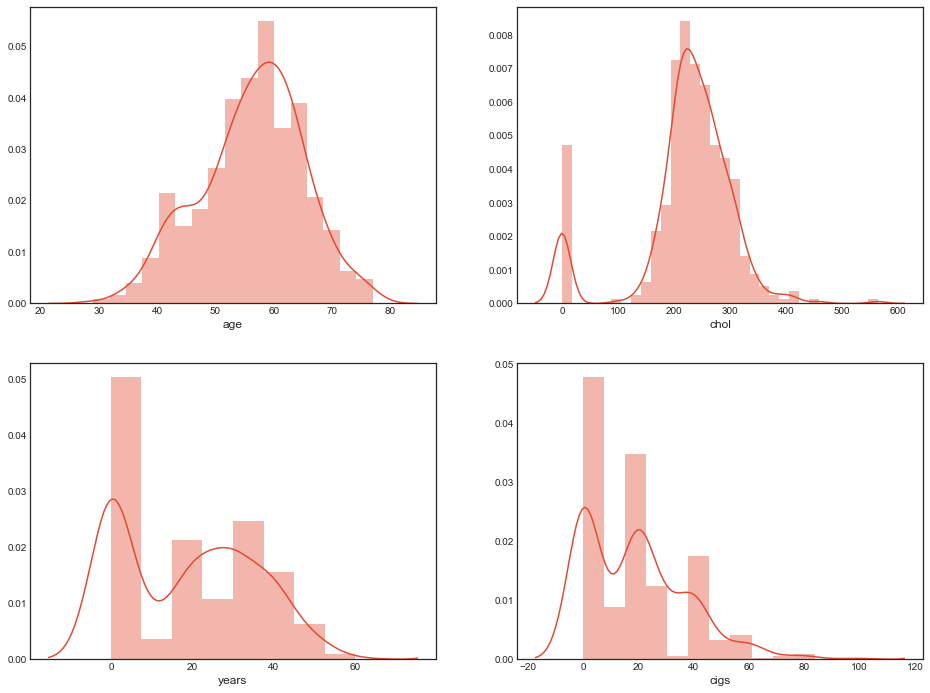

In [314]:
fig, saxis = plt.subplots(2, 2,figsize=(16,12))

sns.distplot(df_raw.age, ax = saxis[0,0])
sns.distplot(df_raw.chol, ax = saxis[0,1])
sns.distplot(df_raw.years, ax = saxis[1,0])
sns.distplot(df_raw.cigs, ax = saxis[1,1])

In [345]:
bins_cols = ["age", "chol", "years", "cigs"]

# Claffify AGE
MIN_AGE = 25; MAX_AGE = 80
df_raw['age_bin'] = df_raw.age.apply(lambda x: int(max(0, x-MIN_AGE)/5) if x < MAX_AGE else int(MAX_AGE/5))

# Classify CHOL
MEDIAN_CHOL = df_raw['chol'].median()
MAX_CHOL = 400; MIN_CHOL = 100
df_raw['chol'] = df_raw['chol'].apply(lambda x: MEDIAN_CHOL if x == 0 else x)
df_raw['chol_bin'] = df_raw['chol'].apply(lambda x: int(max(0, x-MIN_CHOL)/50) if x < MAX_CHOL else int(MAX_CHOL/50))

# Classify CIGS
df_raw['cigs_bin'] = df_raw['cigs'].apply(lambda x: int(x/20) + 1 if x > 0 else 0)

# Classify YEARS
df_raw['years_bin'] = df_raw['years'].apply(lambda x: int(x/10) + 1 if x > 0 else 0)

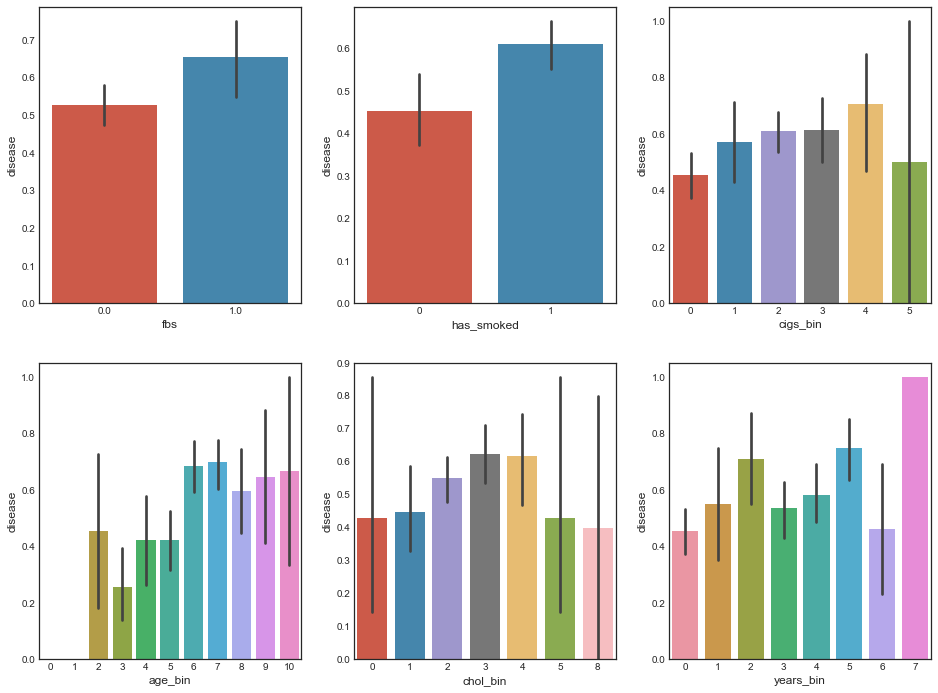

In [346]:
fig, saxis = plt.subplots(2, 3,figsize=(16,12))

sns.barplot(x='fbs', y ='disease', data=df_raw, ax = saxis[0,0])
sns.barplot(x='has_smoked', y ='disease', data=df_raw, ax = saxis[0,1])
sns.barplot(x ='cigs_bin', y ='disease', data=df_raw, ax = saxis[0,2])
sns.barplot(x ='age_bin', y ='disease', data=df_raw, ax = saxis[1,0])
sns.barplot(x ='chol_bin', y ='disease', data=df_raw, ax = saxis[1,1])
sns.barplot(x ='years_bin', y ='disease', data=df_raw, ax = saxis[1,2])

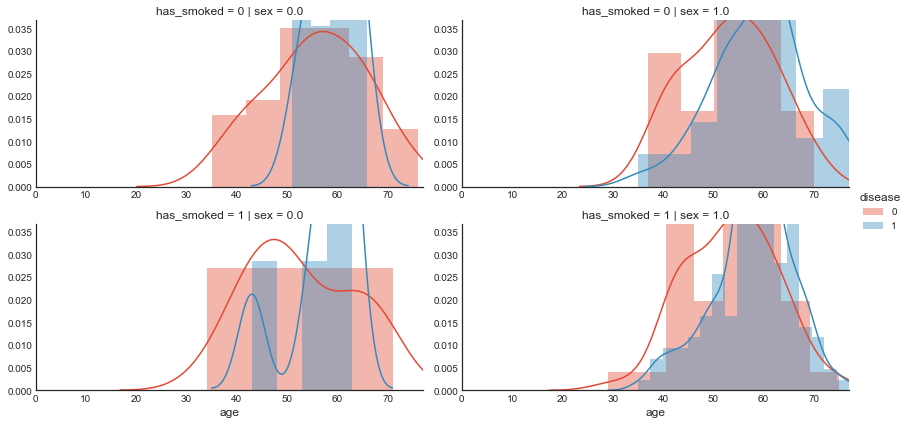

In [347]:
#plot distributions of Age of passengers who survived or did not survive
a = sns.FacetGrid(df_raw , hue='disease', aspect=2, col="sex", row="has_smoked")
a.map(sns.distplot, 'age', norm_hist=False)
a.set(xlim=(0, df_raw['age'].max()))
a.add_legend()

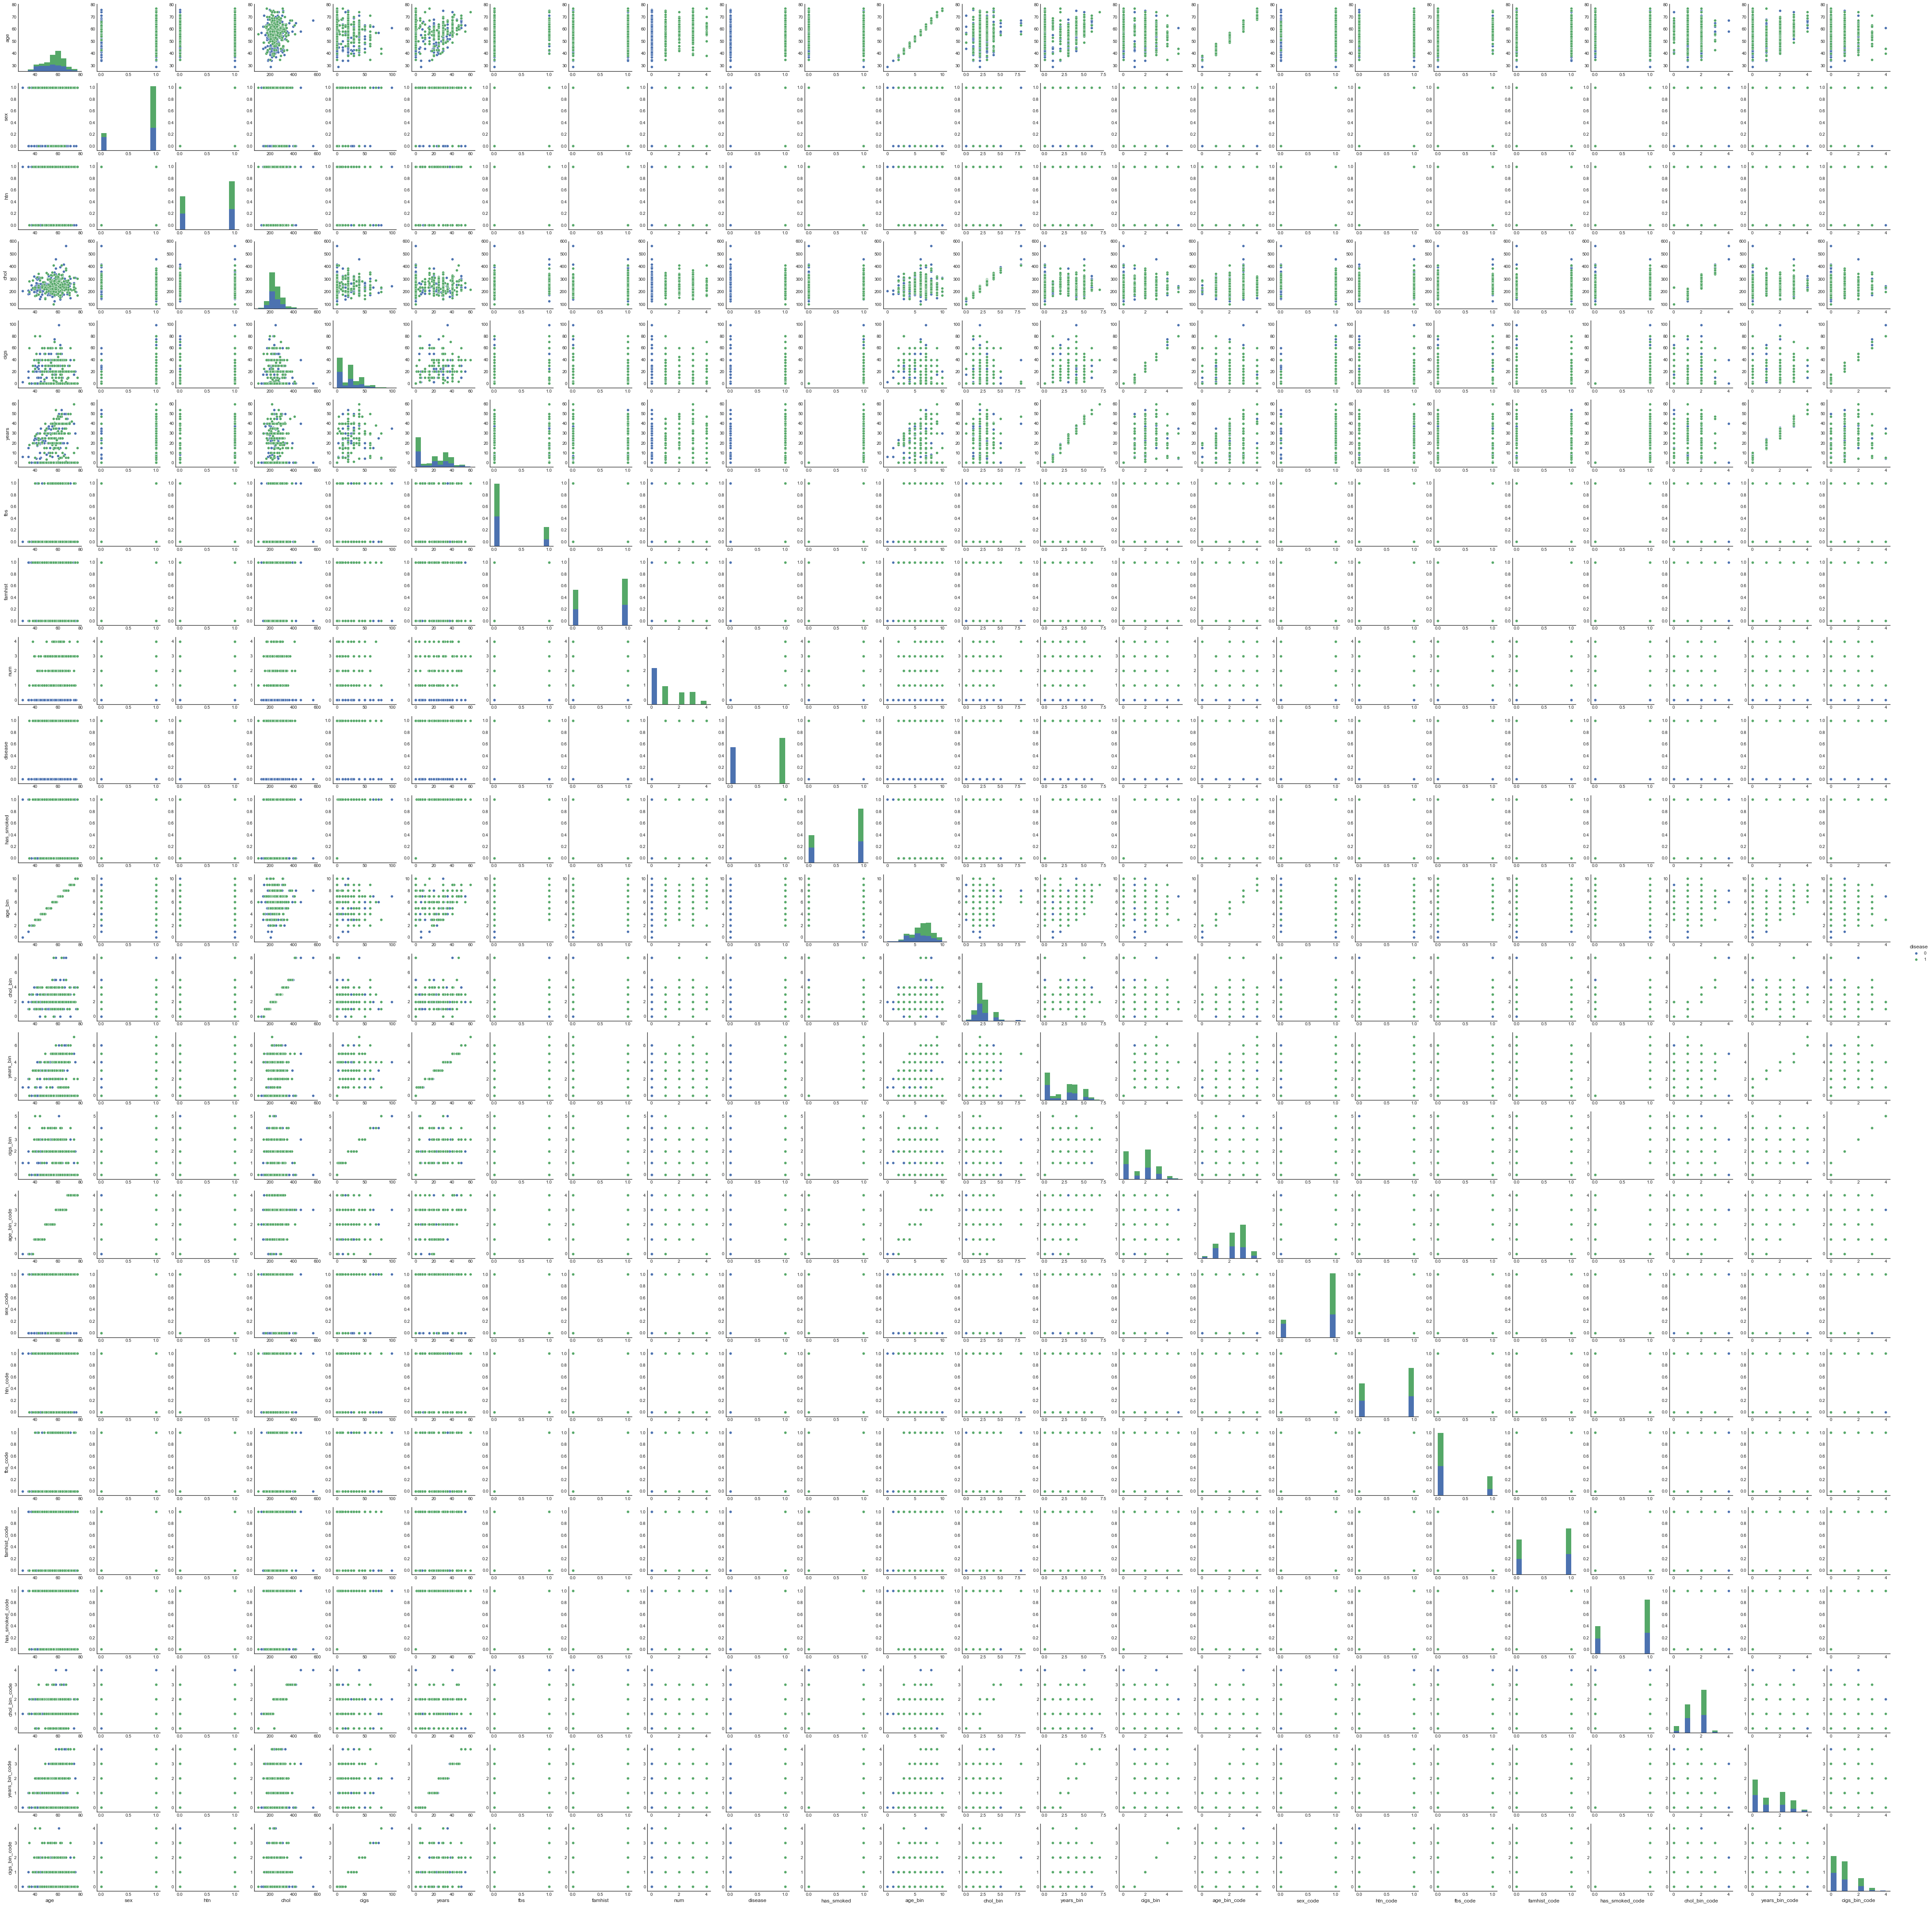

In [348]:
sns.pairplot(df_raw, hue='disease', palette='deep')

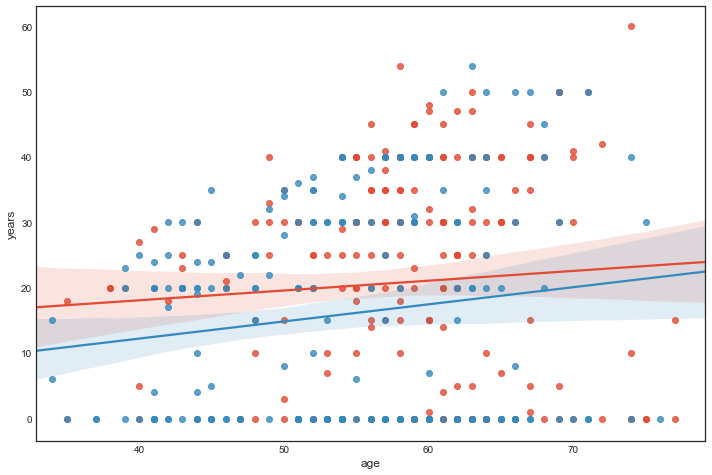

In [216]:
sns.regplot(x="age", y="years", data=df_raw[df_raw.disease == 1])
sns.regplot(x="age", y="years", data=df_raw[df_raw.disease == 0])

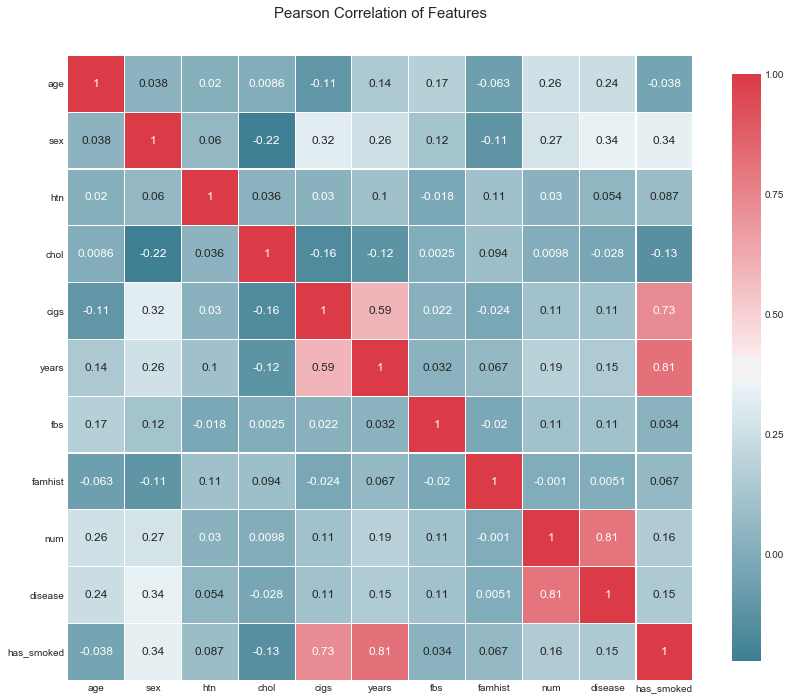

In [220]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(df_raw)

In [221]:
df_raw.columns

Index([u'age', u'sex', u'htn', u'chol', u'cigs', u'years', u'fbs', u'famhist',
       u'num', u'disease', u'has_smoked', u'age_bin', u'chol_bin',
       u'years_bin', u'cigs_bin'],
      dtype='object')

In [370]:
#CONVERT: convert objects to category using Label Encoder for train and test/validation dataset
to_convert = ["age_bin", "sex", "htn", "fbs", "famhist", "has_smoked", "chol_bin", "years_bin", "cigs_bin"]

#code categorical data
label = LabelEncoder()

for t in to_convert:
    df_raw['{}_code'.format(t)] = df_raw[t].astype(int)
    
features = ['{}_code'.format(t) for t in to_convert]
#features = ['age', 'sex_code', 'htn_code', 'chol', 'cigs', 'years', 'fbs_code', 'famhist_code', 'has_smoked_code']
targets = ['disease']

In [371]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #dummy.DummyClassifier(),
    
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model. RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis()
    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=.3, train_size=.6, random_state=0) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy Min' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = df_raw[targets]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, df_raw[features], df_raw[targets], cv=cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    MLA_compare.loc[row_index, 'MLA Test Accuracy Min'] = cv_results['test_score'].min()   #let's know the worst that can happen!

    #save MLA predictions - see section 6 for usage
    alg.fit(df_raw[features], df_raw[targets])
    MLA_predict[MLA_name] = alg.predict(df_raw[features])
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy Min,MLA Time
16,LinearSVC,"{'loss': 'squared_hinge', 'C': 1.0, 'verbose':...",0.693633,0.679104,0.597015,0.0155
6,LogisticRegressionCV,"{'scoring': None, 'n_jobs': 1, 'verbose': 0, '...",0.698876,0.679104,0.619403,0.107
19,LinearDiscriminantAnalysis,"{'solver': 'svd', 'priors': None, 'n_component...",0.692135,0.678358,0.597015,0.00249991
8,RidgeClassifierCV,"{'normalize': False, 'alphas': (0.1, 1.0, 10.0...",0.694007,0.673134,0.589552,0.00339999
3,GradientBoostingClassifier,"{'presort': 'auto', 'loss': 'deviance', 'min_i...",0.831086,0.66194,0.61194,0.0396
12,GaussianNB,{'priors': None},0.675655,0.657463,0.597015,0.00170004
5,GaussianProcessClassifier,"{'warm_start': False, 'kernel': None, 'n_jobs'...",0.869663,0.655224,0.559701,0.0192
0,AdaBoostClassifier,"{'n_estimators': 50, 'base_estimator': None, '...",0.724345,0.653731,0.559701,0.0895
14,SVC,"{'kernel': 'rbf', 'C': 1.0, 'verbose': False, ...",0.74382,0.651493,0.574627,0.0149
15,NuSVC,"{'kernel': 'rbf', 'verbose': False, 'probabili...",0.865169,0.633582,0.574627,0.0251


In [418]:
from sklearn.externals import joblib
MODEL_FOLDER = os.path.join("..", "models")

# SVC
#param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  
#              'C': [1, 10, 100, 1000], #max depth tree can grow; default is none
#              'gamma': ['auto', 0.01, 0.001, 0.0001],
#              'random_state': [0] #seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
#            }

# LinearDiscriminantAnalysis
#param_grid = {'solver': ['lsqr', 'eigen'],  
#              'shrinkage': ['auto', 0.1, 0.01, 0.001], #max depth tree can grow; default is none
#              'n_components': [None, 1, 2, 3],
#              'tol': [0.0001, 0.001, 0.01],
#            }

# Logistic Regression
param_grid = {'penalty': ['l2'],
               'tol': [0.0001, 0.001, 0.00001],
               'random_state': [0],
               'solver': ['newton-cg', 'sag', 'lbfgs']
            }


tune_model = model_selection.GridSearchCV(linear_model.LogisticRegressionCV(), param_grid=param_grid, scoring='roc_auc', cv=cv_split)
tune_model.fit(df_raw[features], df_raw[targets])

model_name = str(tune_model.estimator).split("(")[0]
full_model_name = os.path.join(MODEL_FOLDER, model_name)
joblib.dump(tune_model, '{}.pkl'.format(full_model_name))


['..\\models\\LogisticRegressionCV.pkl']

In [375]:
#print(tune_model.cv_results_.keys())
#print(tune_model.cv_results_['params'])
print('Parameters: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_train_score'])
print("Training score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(tune_model.cv_results_['mean_test_score'])
print("Test score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))

('Parameters: ', {'penalty': 'l2', 'random_state': 0, 'tol': 1e-05, 'solver': 'sag'})
Training score mean: 75.99
Test score mean: 72.70


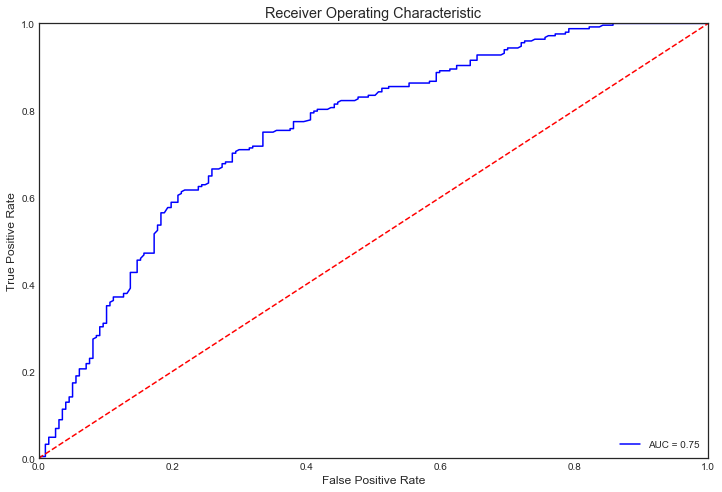

In [376]:
preds = tune_model.predict_proba(df_raw[features])[:,1]

fpr, tpr, threshold = metrics.roc_curve(df_raw['disease'], preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [377]:
metrics.confusion_matrix(df_raw['disease'], tune_model.predict(df_raw[features]))

array([[104,  93],
       [ 44, 204]], dtype=int64)

In [ ]:
["age_code", "sex_code", "htn_code", "fbs_code", "famhist_code", "has_smoked_code", "chol_code", "years_code", "cigs_code"]

In [410]:
# Age int
# Sex 0/1
# HTN 0/1
# FBS 0/1
# Famhist 0/1
# Chol int
# Years int
# Cigs int
# Has smoked

htn = 1
fbs = 1
famhist = 1
sex = 0
age = 54
chol = 200
cigs = 10
years = 30

has_smoked = 1 if cigs or years else 0

# Claffify AGE
MIN_AGE = 25; MAX_AGE = 80
age_bin = int(max(0, age - MIN_AGE)/5) if age < MAX_AGE else int(MAX_AGE/5)

# Classify CHOL
MAX_CHOL = 400; MIN_CHOL = 100
chol_bin = int(max(0, chol - MIN_CHOL)/50) if chol < MAX_CHOL else int(MAX_CHOL/50)

# Classify CIGS
cigs_bin = int(cigs/20) + 1 if x > 0 else 0

# Classify YEARS
years_bin = int(years/10) + 1 if x > 0 else 0

df_test = pd.DataFrame(columns=["htn", "fbs", "famhist", "sex", "age_bin", "chol_bin", "cigs_bin", "years_bin", "has_smoked"],
                      data=[[htn, fbs, famhist, sex, age_bin, chol_bin, cigs_bin, years_bin, has_smoked]])

for t in to_convert:
    df_test['{}_code'.format(t)] = df_test[t].astype(int)

In [419]:
clf = joblib.load('{}.pkl'.format(full_model_name)) 
clf.predict_proba(df_test[features])

array([[ 0.82542967,  0.17457033]])

In [392]:
tune_model.classes_

array([0, 1], dtype=int64)

'LogisticRegressionCV'